In [1]:
import torch
from dcdi.models.forward_model import ForwardModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

No intervention


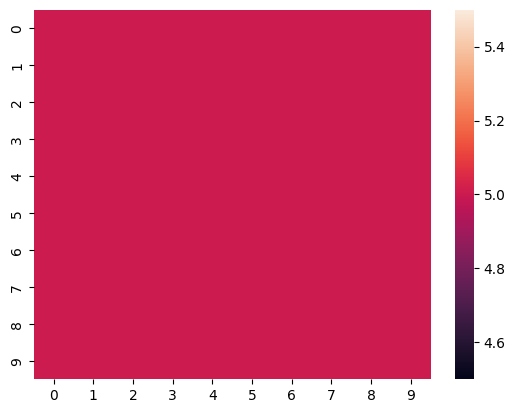

In [2]:
batch_size = 1000
num_vars = 10
num_layers = 3
hid_dim = 32
num_params = 1
lr = 1e-3
sparsity_coeff = 0.001

torch.set_default_tensor_type('torch.cuda.FloatTensor')
#torch.set_default_tensor_type('torch.DoubleTensor')

model = ForwardModel(num_vars, num_layers, hid_dim, num_params, nonlin="leaky-relu", intervention=False)

sns.heatmap(model.gumbel_adjacency.log_alpha.detach().cpu().numpy())

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

In [4]:
from tqdm.auto import tqdm

losses = list()
reg_losses = list()

shifted_indices = list(range(1,num_vars)) + [0]

for i in tqdm(range(50000)):
    x = torch.randn((batch_size,num_vars)).detach()
    
    y_pred = model(x)    
    y_true = x + x[:,shifted_indices]
    
    mse = ((y_true - y_pred.squeeze())**2).mean()
    
    w_adj = model.get_w_adj()
    adj_norm = torch.norm(w_adj, p=1)
    adj_norm = adj_norm / (w_adj.shape[0]**2)
    reg_sparsity = sparsity_coeff * adj_norm
    loss = mse + reg_sparsity.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    
    
    losses.append(mse.item())
    reg_losses.append(adj_norm.item())
    

  0%|          | 0/50000 [00:00<?, ?it/s]

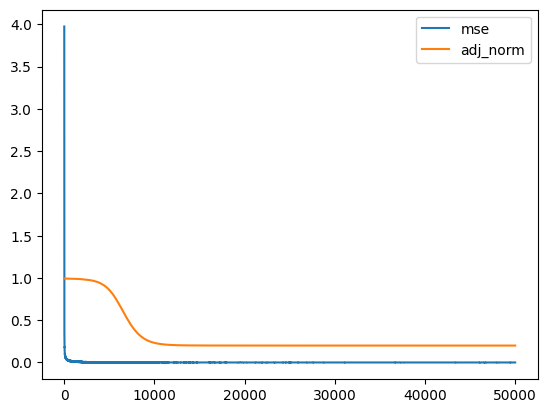

In [5]:
plt.figure()
plt.plot(losses, label = 'mse')
plt.plot(reg_losses, label = 'adj_norm')
plt.legend()
#plt.ylim(0.0,2.0)
plt.show()

In [6]:
x_test = torch.randn((batch_size,num_vars))
print(x_test.shape)

torch.Size([1000, 10])


In [8]:
y_test = model(x_test)
y_test_true = x_test + x_test[:,shifted_indices]

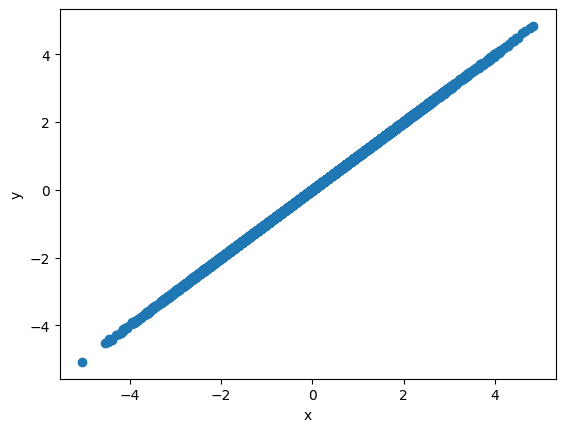

In [9]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(y_test_true.reshape((-1,)).detach().cpu().numpy(), y_test.reshape((-1,)).detach().cpu().numpy())

<AxesSubplot: >

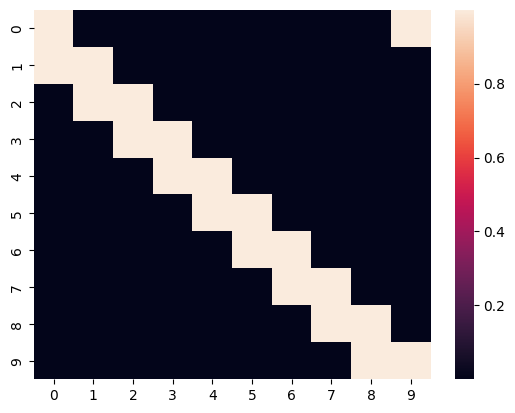

In [10]:
import seaborn as sns
w_adj = model.get_w_adj()
sns.heatmap(w_adj.cpu().detach().numpy())